In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from timm.models.swin_transformer import SwinTransformer
import numpy as np
import os
import cv2
import random
import shutil
from tqdm import tqdm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])


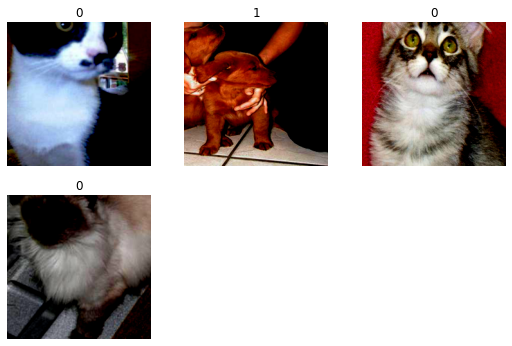

In [2]:
BATCH_SIZE=4
EPOCH=50
lr=0.0001
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

valid_transform=transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
test_transform=transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
train_dataset =torchvision.datasets.ImageFolder(root='./dataset/train/',transform=train_transform)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True,num_workers=2)

val_dataset = torchvision.datasets.ImageFolder(root='./dataset/val/',transform=valid_transform)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.ImageFolder(root='./dataset/test/',transform=test_transform)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

images, labels = next(iter(train_loader))
print(images.size())  # torch.Size([9, 1, 28, 28])
#plt.figure(figsize=(9, 9))
plt.figure(figsize=(9,9))
for i in range(BATCH_SIZE):
    plt.subplot(3, 3, i+1)
    plt.title(labels[i].item())
    plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
plt.show()

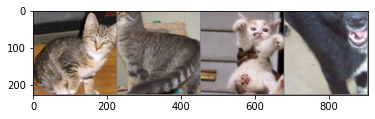

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5  # 反标准化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取一个批次的训练图片、标签并显示
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images))


In [4]:
!wget https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth


'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [14]:
swin_tiny_cfg = dict(patch_size=4, window_size=7, embed_dim=96, depths=(2, 2, 6, 2), num_heads=(3, 6, 12, 24))
swin_tiny = SwinTransformer(**swin_tiny_cfg)



In [21]:
import logging
import math
from functools import partial
from typing import Optional
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        self.backbone = SwinTransformer(**swin_tiny_cfg)
        self.backbone.load_state_dict(
            torch.load('./pretrained_model/swin_tiny_patch4_window7_224.pth',
                       map_location=torch.device(device))['model'], strict=True)
        self.backbone.num_classes=2
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Swin Transformer  https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer.py
        def forward_features(self, x):
              x = self.patch_embed(x)
              if self.absolute_pos_embed is not None:
                  x = x + self.absolute_pos_embed
              x = self.pos_drop(x)
              x = self.layers(x)
              x = self.norm(x)  # B L C
              x = self.avgpool(x.transpose(1, 2))  # B C 1
              x = torch.flatten(x, 1)
              return x

        def forward(self, x):
              x = self.forward_features(x)
              x = self.head(x)
              return x
        """
        x = self.backbone.forward_features(x) # [batch_size, 768]
        x=torch.mean(x,dim=1)
        # print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)    # [batch_size, 2]
        return x


In [22]:
swin_T = Net()
swin_T=swin_T.to(device)

In [23]:
input = torch.randn((4, 3, 224, 224))
input=input.to(device)
output=swin_T(input)
print(output.shape)
def get_parameter_number(model_analyse):
    #  打印模型参数量
    total_num = sum(p.numel() for p in model_analyse.parameters())
    trainable_num = sum(p.numel() for p in model_analyse.parameters() if p.requires_grad)
    return 'Total parameters: {}, Trainable parameters: {}'.format(total_num, trainable_num)
get_parameter_number(swin_T)


torch.Size([4, 2])


'Total parameters: 28485732, Trainable parameters: 28485732'

In [ ]:
print(output)

Code below are the process of train and valid

In [27]:
optimizer = optim.SGD(swin_T.parameters(), lr=lr,
                      momentum=momentum)
def evaluate_accuracy(data_iter, net,epoch, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    if acc_sum / n > 0.9:
        torch.save(net,'./trained_model/epoch %d acc %.3f.pth'% ((epoch+1),(acc_sum / n)))
    return acc_sum / n 

def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.cuda()
    print("training on ", device)
    Loss_list = []
    Accuracy_train_list = []
    Accuracy_test_list = []

    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.cuda()
            y = y.cuda()
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net,epoch)
        Loss_list.append(train_l_sum / batch_count)
        Accuracy_train_list.append(100 *(train_acc_sum / n))
        Accuracy_test_list.append(100*test_acc)

        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    
    x1 = range(0,EPOCH)
    
    plt.subplot(1,3,1)
    plt.plot(x1,Loss_list)
    plt.legend(['train_loss'])
    plt.subplot(1,3,2)
    plt.plot(x1,Accuracy_train_list)
    plt.legend(['train_acc'])
    plt.subplot(1,3,3)
    plt.plot(x1,Accuracy_test_list)
    plt.legend(['test_acc'])
    #plt.legend(['train_loss','train_acc','test_loss'])
    
    plt.show()



training on  cuda
epoch 1, loss 0.2185, train acc 0.954, test acc 0.992, time 266.6 sec
epoch 2, loss 0.0702, train acc 0.973, test acc 0.992, time 268.5 sec
epoch 3, loss 0.0586, train acc 0.976, test acc 0.992, time 264.0 sec
epoch 4, loss 0.0567, train acc 0.979, test acc 0.993, time 265.7 sec
epoch 5, loss 0.0522, train acc 0.980, test acc 0.993, time 264.9 sec
epoch 6, loss 0.0501, train acc 0.981, test acc 0.992, time 261.5 sec
epoch 7, loss 0.0497, train acc 0.981, test acc 0.993, time 258.9 sec
epoch 8, loss 0.0478, train acc 0.981, test acc 0.994, time 258.6 sec
epoch 9, loss 0.0492, train acc 0.980, test acc 0.994, time 259.8 sec
epoch 10, loss 0.0448, train acc 0.983, test acc 0.993, time 260.5 sec
epoch 11, loss 0.0410, train acc 0.984, test acc 0.993, time 257.6 sec
epoch 12, loss 0.0437, train acc 0.983, test acc 0.993, time 258.5 sec
epoch 13, loss 0.0422, train acc 0.984, test acc 0.994, time 304.5 sec
epoch 14, loss 0.0406, train acc 0.984, test acc 0.993, time 254.7 s

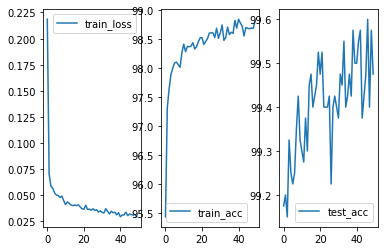

In [28]:
#train(EPOCH)
train(swin_T,train_loader,val_loader,BATCH_SIZE,optimizer,device,EPOCH)